# **Ansatz HEA 2D brickwork para VQA**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Creado por: **Sebastián González Juárez**


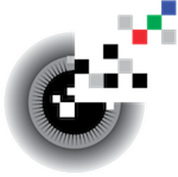
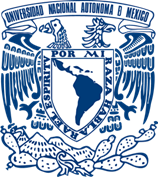

## Resumen.

En este notebook trabajaremos un VQA con el conjunto Digits, filtrando 0 vs 1, reduciendo 8×8 → 4×4 (16 features → 16 qubits).

**Usando el ansatz HEA 2D brickwork**

## 1) Instalación e importaciones

In [1]:
!pip install pennylane --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
import json
import zipfile
import os

Semilla para reproducibilidad.

In [3]:
SEED = 42
rng = np.random.default_rng(SEED)

## 2) Configuración y utilidades de datos (Digits 0 vs 1, 8×8→4×4)

Hiperparámetros de datos

In [4]:
n_rows, n_cols = 4, 4                     # Rejilla 4x4 -> 16 qubits
n_qubits = n_rows * n_cols                # Total de qubits = 16

Reduce una imagen 8x8 a 4x4 promediando bloques 2x2.

In [5]:
def downsample_8x8_to_4x4(img8):
    small = img8.reshape(4,2,4,2).mean(axis=(1,3))  # Promedio de cada bloque 2x2
    return small                                    # Devuelve (4,4)

  Carga Digits, filtra clases 0 y 1, reduce 8x8 -> 4x4 y normaliza.
  

In [6]:
def load_digits_binary_0_1(test_size=0.2, seed=SEED):
    data = load_digits()                             # Carga dataset (imagenes 8x8, etiquetas 0..9)
    X_all, y_all = data.images, data.target          # X_all: (N,8,8), y_all: (N,)
    mask = (y_all == 0) | (y_all == 1)               # Filtra solo 0 y 1
    X01 = X_all[mask]                                # Imágenes 0/1
    y01 = y_all[mask].astype(np.int64)               # Etiquetas 0/1

    X_small = np.stack([downsample_8x8_to_4x4(im) for im in X01], axis=0)  # (N,4,4)

    X_small = (X_small - X_small.min()) / (X_small.max() - X_small.min() + 1e-9)  # Escala segura

    X_small = X_small.reshape(-1, 16).astype(np.float32)  # (N,16)

    # Train/test con estratificación para mantener proporciones
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_small, y01, test_size=test_size, random_state=seed, stratify=y01
    )
    return X_tr, X_te, y_tr, y_te


Carga datos (0 vs 1)

In [7]:
X_tr, X_te, y_tr, y_te = load_digits_binary_0_1(test_size=0.2, seed=SEED)  # Llama a la función
print("Shapes ->", X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)          # Revisa dimensiones
print("Clases en train ->", np.bincount(y_tr))                              # Conteo de clases (train)
print("Clases en test  ->", np.bincount(y_te))                              # Conteo de clases (test)

Shapes -> (288, 16) (72, 16) (288,) (72,)
Clases en train -> [142 146]
Clases en test  -> [36 36]


## 3. Conectividad 2D y patrones brickwork

Rejilla y numeración de wires.

In [8]:
def rc_to_wire(r, c, n_cols):
    return r * n_cols + c                   # Índice lineal en orden por filas

Aristas horizontales y verticales tipo brickwork.

In [9]:
def horizontal_edges(n_rows, n_cols, offset=0):
    edges = []                              # Lista de pares (a,b)
    for r in range(n_rows):                 # Recorre filas
        for c in range(offset, n_cols - 1, 2):     # Salta 2 con desplazamiento
            a = rc_to_wire(r, c, n_cols)           # Índice wire a
            b = rc_to_wire(r, c + 1, n_cols)       # Índice wire b
            edges.append((a, b))                   # Agrega par
    return edges                                 # Devuelve lista

In [10]:
def vertical_edges(n_rows, n_cols, offset=0):
    edges = []                              # Lista de pares (a,b)
    for c in range(n_cols):                 # Recorre columnas
        for r in range(offset, n_rows - 1, 2):     # Salta 2 con desplazamiento
            a = rc_to_wire(r, c, n_cols)           # Índice wire a
            b = rc_to_wire(r + 1, c, n_cols)       # Índice wire b
            edges.append((a, b))                   # Agrega par
    return edges                                 # Devuelve lista

Vistazo rápido de cuántas aristas se forman por offset

In [11]:
print("Horiz offset0:", len(horizontal_edges(n_rows, n_cols, 0)),
      "| offset1:", len(horizontal_edges(n_rows, n_cols, 1)))
print("Vert  offset0:", len(vertical_edges(n_rows, n_cols, 0)),
      "| offset1:", len(vertical_edges(n_rows, n_cols, 1)))

Horiz offset0: 8 | offset1: 4
Vert  offset0: 8 | offset1: 4


## 4. Dispositivo, feature map y ansatz HEA 2D brickwork

Hiperparámetros del modelo cuántico

In [12]:
n_layers = 4                                # Profundidad del HEA (ajustable)
shots = None                                # None = expectativas analíticas (entrena más rápido)
dev = qml.device("default.qubit", wires=n_qubits, shots=shots)  # Dispositivo simulado

Feacture Map.

In [13]:
def encode_features(x):
    angles = qnp.array(np.pi * x, requires_grad=False)  # Ángulos (no entrenables)
    for i in range(n_qubits):                           # Recorre qubits
        qml.RY(angles[i], wires=i)                      # Aplica RY(ángulo) en cada wire

Ansatz HEA 2D: por capa aplica rotaciones locales y acoplamientos CZ brickwork H/V alternados.

weights: arreglo de forma (n_layers, n_qubits, 2) para RY y RZ por qubit.

In [14]:
def hea_2d_brickwork(weights):
    for l in range(n_layers):                                         # Por cada capa
        for w in range(n_qubits):                                     # Rotaciones locales
            qml.RY(weights[l, w, 0], wires=w)                         # RY entrenable
            qml.RZ(weights[l, w, 1], wires=w)                         # RZ entrenable
        for (a, b) in horizontal_edges(n_rows, n_cols, offset=(l % 2)):        # Brick H
            qml.CZ(wires=[a, b])                                      # CZ en par horizontal
        for (a, b) in vertical_edges(n_rows, n_cols, offset=((l + 1) % 2)):    # Brick V
            qml.CZ(wires=[a, b])                                      # CZ en par vertical

## 5) QNode (multi-readout) y probabilidad clase 1

Circuito: encoding -> HEA -> devuelve vector de <Z> en los 16 qubits.

In [15]:
@qml.qnode(dev, interface="autograd")
def circuit_multi(x, weights):
    encode_features(x)                                 # Inserta datos
    hea_2d_brickwork(weights)                          # Aplica ansatz
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  # Vector <Z> (16,)

Sigmoide estable: 1/(1+exp(-t)).

In [16]:
def sigmoid(t):
    return 1.0 / (1.0 + qnp.exp(-t))                   # Función logística

  Predicción de probabilidad de clase 1 a partir de z_vec y capa de lectura clásica.
  
  p = sigmoid( - z_vec · w_read + b_read )

In [17]:
def proba_class1(x, weights, w_read, b_read):
    z_vec = qnp.array(circuit_multi(x, weights))       # Ejecuta QNode -> vector <Z>
    logit = - qnp.dot(z_vec, w_read) + b_read          # Logit lineal (signo negativo alinear mapeo)
    return sigmoid(logit)                              # Probabilidad en [0,1]

## 6) Pérdida, exactitud y mini-batches

Binary Cross-Entropy + regularización L2 sobre pesos cuánticos y de lectura.

In [18]:
def bce_loss(weights, w_read, b_read, Xb, yb, l2_lambda=0.0, eps=1e-9):
    losses = []                                                     # Acumula pérdidas por muestra
    for x, y in zip(Xb, yb):                                        # Itera lote
        p = proba_class1(x, weights, w_read, b_read)                # Probabilidad predicha
        p = qnp.clip(p, eps, 1 - eps)                               # Evita log(0)
        losses.append(-(y * qnp.log(p) + (1 - y) * qnp.log(1 - p))) # BCE punto a punto
    data_loss = qnp.mean(qnp.stack(losses))                         # Promedio del lote

    # Regularización L2 (sobre todos los parámetros)
    l2_q = qnp.sum(weights**2)                                      # Norma L2 de pesos cuánticos
    l2_r = qnp.sum(w_read**2) + b_read**2                           # Norma L2 de lectura
    return data_loss + l2_lambda * (l2_q + l2_r)                    # Pérdida total

Accuracy (umbral 0.5).

In [19]:
def accuracy(weights, w_read, b_read, Xb, yb):
    preds = []                                                      # Lista de predicciones
    for x in Xb:                                                    # Recorre ejemplos
        p = proba_class1(x, weights, w_read, b_read)                # Probabilidad
        preds.append((p >= 0.5).astype(int))                        # Binariza con 0.5
    preds = qnp.array(preds)                                        # A qnp array
    return qnp.mean((preds == yb).astype(qnp.float32))              # Promedio de aciertos


Generador de mini-batches barajados.

In [20]:
def iter_minibatches(X, y, batch_size, seed=SEED):
    N = len(X)                                                      # Número total de muestras
    idx = np.arange(N)                                              # Índices
    rng = np.random.default_rng(seed)                               # RNG reproducible
    rng.shuffle(idx)                                                # Baraja
    for start in range(0, N, batch_size):                           # Recorre por lotes
        sl = idx[start:start + batch_size]                          # Slice del lote
        yield X[sl], y[sl]                                          # Devuelve lote

## 7) Inicialización, optimizador y entrenamiento

Hiperparámetros de entrenamiento

In [21]:
batch_size = 64                         # Tamaño de mini-lote
epochs = 10                             # Épocas
stepsize = 0.03                         # Tasa de aprendizaje (Adam)
l2_lambda = 1e-4                        # Regularización L2

Inicialización de pesos cuánticos: (n_layers, n_qubits, 2) para RY y RZ

In [22]:
weights = 0.01 * qnp.array(             # Escala pequeña para evitar mesetas
    rng.standard_normal((n_layers, n_qubits, 2)),
    requires_grad=True
)

Inicialización de la capa de lectura (clásica)

In [23]:
w_read = qnp.array(                     # Vector de pesos de lectura (16,)
    np.zeros(n_qubits, dtype=np.float32),
    requires_grad=True
)
b_read = qnp.array(0.0, requires_grad=True)  # Sesgo (escalar) entrenable

Optimizador (Adam recomendado para estabilidad).

In [24]:
opt = qml.AdamOptimizer(stepsize=stepsize)   # Optimizador Adam

Historial de métricas

In [25]:
history = {"epoch": [], "loss": [], "acc_tr": [], "acc_te": []}  # Diccionario

Bucle de entrenamiento

In [26]:
for epoch in range(1, epochs + 1):                                       # Recorre épocas
    for Xb, yb in iter_minibatches(X_tr, y_tr, batch_size, seed=SEED+epoch):  # Mini-batches
        # Un paso de optimización: actualiza (weights, w_read, b_read)
        weights, w_read, b_read = opt.step(
            lambda W, WR, BR: bce_loss(W, WR, BR, Xb, yb, l2_lambda),
            weights, w_read, b_read
        )
    # Métricas al final de la época (completas)
    tr_loss = bce_loss(weights, w_read, b_read, X_tr, y_tr, l2_lambda)   # Pérdida train
    tr_acc  = accuracy(weights, w_read, b_read, X_tr, y_tr)              # Accuracy train
    te_acc  = accuracy(weights, w_read, b_read, X_te, y_te)              # Accuracy test

    # Guarda historial
    history["epoch"].append(epoch)                                       # Época
    history["loss"].append(float(tr_loss))                                # Pérdida
    history["acc_tr"].append(float(tr_acc))                               # Acc train
    history["acc_te"].append(float(te_acc))                               # Acc test

    # Imprime progreso
    print(f"Época {epoch:02d} | Loss {tr_loss:.4f} | Acc(train) {tr_acc:.3f} | Acc(test) {te_acc:.3f}")

Época 01 | Loss 0.5653 | Acc(train) 0.840 | Acc(test) 0.861
Época 02 | Loss 0.4371 | Acc(train) 0.906 | Acc(test) 0.819
Época 03 | Loss 0.3520 | Acc(train) 0.889 | Acc(test) 0.819
Época 04 | Loss 0.2862 | Acc(train) 0.917 | Acc(test) 0.875
Época 05 | Loss 0.2443 | Acc(train) 0.934 | Acc(test) 0.889
Época 06 | Loss 0.2123 | Acc(train) 0.944 | Acc(test) 0.903
Época 07 | Loss 0.1851 | Acc(train) 0.958 | Acc(test) 0.958
Época 08 | Loss 0.1658 | Acc(train) 0.962 | Acc(test) 0.986
Época 09 | Loss 0.1528 | Acc(train) 0.965 | Acc(test) 0.944
Época 10 | Loss 0.1393 | Acc(train) 0.972 | Acc(test) 0.986


## 8) Evaluación, gráficas y guardado/descarga

Accuracy final

In [27]:
final_tr_acc = accuracy(weights, w_read, b_read, X_tr, y_tr)            # Acc final train
final_te_acc = accuracy(weights, w_read, b_read, X_te, y_te)            # Acc final test
print("\n== Evaluación final ==")                                       # Encabezado
print(f"Accuracy final (train): {float(final_tr_acc):.3f}")             # Imprime train
print(f"Accuracy final (test) : {float(final_te_acc):.3f}")             # Imprime test


== Evaluación final ==
Accuracy final (train): 0.972
Accuracy final (test) : 0.986


Predicciones en test y matriz de confusión

In [28]:
y_pred = np.array([int((proba_class1(x, weights, w_read, b_read) >= 0.5)) for x in X_te])  # Predicciones binarias
cm = confusion_matrix(y_te, y_pred)                                        # Matriz de confusión
print("\nMatriz de confusión (test):")                                     # Encabezado
print(cm)                                                                  # Imprime matriz
print("\nReporte de clasificación (test):")                                # Encabezado
print(classification_report(y_te, y_pred, digits=3))                       # Reporte macro


Matriz de confusión (test):
[[35  1]
 [ 0 36]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.973     1.000     0.986        36

    accuracy                          0.986        72
   macro avg      0.986     0.986     0.986        72
weighted avg      0.986     0.986     0.986        72



Curvas de entrenamiento (Loss y Accuracy)

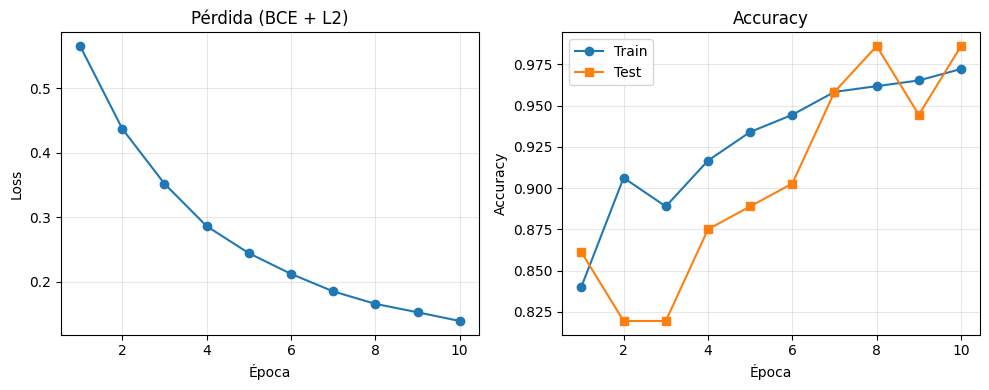

In [29]:
plt.figure(figsize=(10,4))                                                 # Figura
plt.subplot(1,2,1)                                                         # Subplot 1
plt.plot(history["epoch"], history["loss"], marker="o")                    # Pérdida
plt.title("Pérdida (BCE + L2)")                                            # Título
plt.xlabel("Época")                                                        # Eje X
plt.ylabel("Loss")                                                         # Eje Y
plt.grid(True, alpha=0.3)                                                  # Cuadrícula

plt.subplot(1,2,2)                                                         # Subplot 2
plt.plot(history["epoch"], history["acc_tr"], marker="o", label="Train")   # Acc train
plt.plot(history["epoch"], history["acc_te"], marker="s", label="Test")    # Acc test
plt.title("Accuracy")                                                      # Título
plt.xlabel("Época")                                                        # Eje X
plt.ylabel("Accuracy")                                                     # Eje Y
plt.legend()                                                               # Leyenda
plt.grid(True, alpha=0.3)                                                  # Cuadrícula
plt.tight_layout()                                                         # Ajuste
plt.savefig("training_curves.png", dpi=150)                                # Guarda imagen
plt.show()                                                                 # Muestra

Guardar pesos y artefactos

In [30]:
np.save("hea_weights.npy", np.array(weights))                               # Pesos cuánticos
np.save("readout_w.npy", np.array(w_read))                                  # Pesos lectura
np.save("readout_b.npy", np.array(b_read))                                  # Sesgo lectura

Guardar pesos también en JSON (portable)

In [31]:
with open("hea_weights.json", "w") as f:                                    # Abre JSON
    json.dump({"weights": np.array(weights).tolist()}, f)                   # Escribe pesos

Guardar imagen de matriz de confusión

In [32]:
plt.figure(figsize=(4,4))                                                   # Figura
plt.imshow(cm, cmap="Blues")                                                # Heatmap
plt.title("Matriz de confusión (test)")                                     # Título
plt.xlabel("Predicción")                                                    # Eje X
plt.ylabel("Etiqueta real")                                                 # Eje Y
for i in range(cm.shape[0]):                                                # Recorre filas
    for j in range(cm.shape[1]):                                            # Recorre columnas
        plt.text(j, i, cm[i, j], ha="center", va="center")                  # Pone número en celda
plt.tight_layout()                                                          # Ajuste
plt.savefig("confusion_matrix.png", dpi=150)                                # Guarda imagen
plt.close()                                                                 # Cierra figura

Empaquetar artefactos en ZIP

In [33]:
with zipfile.ZipFile("run_artifacts.zip", "w", zipfile.ZIP_DEFLATED) as z:  # Crea ZIP
    for fname in ["hea_weights.npy", "readout_w.npy", "readout_b.npy",
                  "hea_weights.json", "training_log.csv",
                  "training_curves.png", "confusion_matrix.png"]:
        if os.path.exists(fname):                                           # Verifica archivos
            z.write(fname)                                                  # Agrega al ZIP

Descargar desde Colab

In [34]:
print("\nDescargando 'run_artifacts.zip' ...")                              # Mensaje
files.download("run_artifacts.zip")                                          # Descarga


Descargando 'run_artifacts.zip' ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>